In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import itertools as itool
import ast 
import pickle
from collections import defaultdict
from scipy.cluster import hierarchy
from scipy.spatial import distance

In [2]:
venues_nw=pd.read_csv("venues_edges.csv", encoding='latin-1')

In [51]:
venues_nw.columns

Index(['EdgeID', 'FromNodeID', 'ToNodeID', 'Number of Shared Groups',
       'Shared Groups', 'Common Topics of Groups'],
      dtype='object')

In [4]:
venues_nw.head()

,EdgeID,FromNodeID,ToNodeID,Number of Shared Groups,Shared Groups,Common Topics of Groups
0,0,23729697,24517127,3,"[1627081, 1188778, 5817262]",[]
1,1,24517127,23729697,3,"[1627081, 1188778, 5817262]",[]
2,2,23729697,724783,1,[5817262],"['New Technology', 'Web Technology', 'Technolo..."
3,3,724783,23729697,1,[5817262],"['New Technology', 'Web Technology', 'Technolo..."
4,4,23729697,14982352,1,[5817262],"['New Technology', 'Web Technology', 'Technolo..."


In [82]:
venues_NW = nx.from_pandas_edgelist(
        df = venues_nw,
        source = 'FromNodeID',
        target = 'ToNodeID', 
        edge_attr = 'Number of Shared Groups')

In [83]:
venues_weights = venues_nw["Number of Shared Groups"].tolist()

In [ ]:
pos 

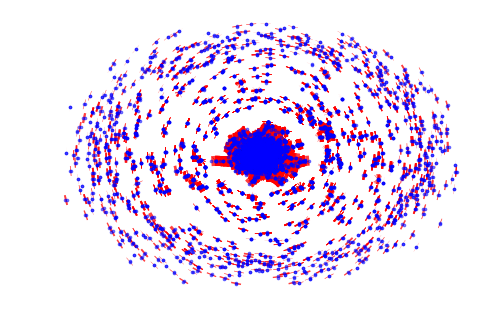

In [56]:
fig = plt.figure(figsize=(15,12)
nx.draw(venues_NW, with_labels=False, 
                             width=10, alpha=.5 ,node_size=7, node_color = "Blue", edge_color="Red", linewidths=1, label="Venues Network")
plt.show()
fig.savefig('venue_nw.png')

In [9]:
lengths = dict(nx.all_pairs_shortest_path_length(venues_NW))

In [10]:
with open(r"venue_shortest_path_lengths.pickle", "wb") as output_file:
    pickle.dump(lengths, output_file)

In [61]:
with open(r"venue_shortest_path_lengths.pickle", "rb") as input_file:
    lengths = pickle.load(input_file)

In [62]:
max_dist = max([max(t.values()) for s,t in lengths.items()])

In [9]:
def create_dist_matrix(G, path_length=lengths):
    distances=np.zeros((len(G),len(G)))
    i=0
    for source,targets in path_length.items():
        j=0
        for target,distance in targets.items():
            distances[i][j]=distance
            distances[j][i]=distance
            if i==j: distances[i][j]=0
            j+=1
        i+=1
    return distances

In [10]:
dist_matrix = create_dist_matrix(venues_NW)

In [11]:
with open(r"distance_matrix", "wb") as output_file:
    pickle.dump(dist_matrix, output_file)

In [63]:
with open(r"distance_matrix", "rb") as input_file:
    dist_matrix = pickle.load(input_file)

In [84]:
def create_hc(G, clust_no, dist_matrix):
  labels = list(G.nodes())
  Y=distance.squareform(dist_matrix)
  Z=hierarchy.linkage(Y, method="ward")  # Creates HC using ward
  
  #flatten the hc
  membership=list(hierarchy.fcluster(Z, t=clust_no, criterion="maxclust"))
  
  # Create collection of lists for blockmodel
  partition=defaultdict(list)
  for n,p in zip(list(range(len(G))),membership):
      partition[p].append(labels[n])
  return partition, membership, Z

In [85]:
partition, f_clust, h_clust = create_hc(venues_NW, 10, dist_matrix)

In [86]:
partition_list = list(partition.values())

In [54]:
with open(r"hc_linkage_matrix.pickle", "wb") as output_file1:
     pickle.dump(h_clust,output_file1)
with open(r"flat_clust.pickle", "wb") as output_file2:
     pickle.dump(f_clust,output_file2)
with open(r"partition_map_of_nodes_fclust.pickle", "wb") as output_file3:
     pickle.dump(partition, output_file3)

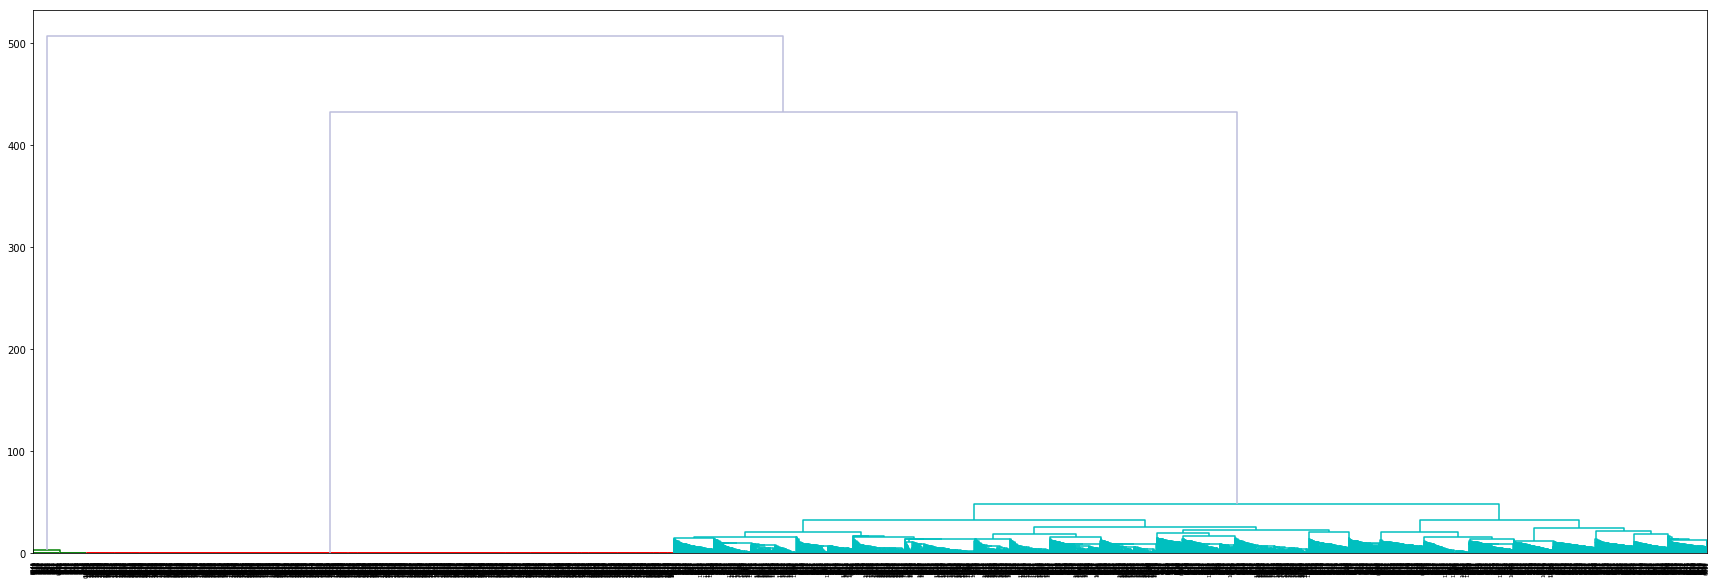

In [68]:
fig = plt.figure(figsize=(30, 10))
dn = hierarchy.dendrogram(h_clust, p=100, truncate_mode = "level", show_leaf_counts=True, above_threshold_color='#bcbddc')
plt.show()
fig.savefig('dendo15.png')

## Block Model

In [87]:
BM = nx.quotient_graph(venues_NW, partition_list, relabel=True)

In [88]:
pos = nx.spring_layout(venues_NW,k=10)
print("layout calculation done")

layout calculation done


In [104]:
# Draw block model with weighted(by number of shared groups) edges and nodes sized by number of venues in them
node_size = [BM.nodes[x]['nnodes'] * 2.5 for x in BM.nodes()]
edge_width=[(.0008*d['weight']) for (u,v,d) in BM.edges(data=True)]
# Set positions to mean of positions of internal nodes from original graph


posBM = {}
for n  in BM:
    xy = np.array([pos[u] for u in BM.nodes[n]['graph']])
    posBM[n] = xy.mean(axis=0)

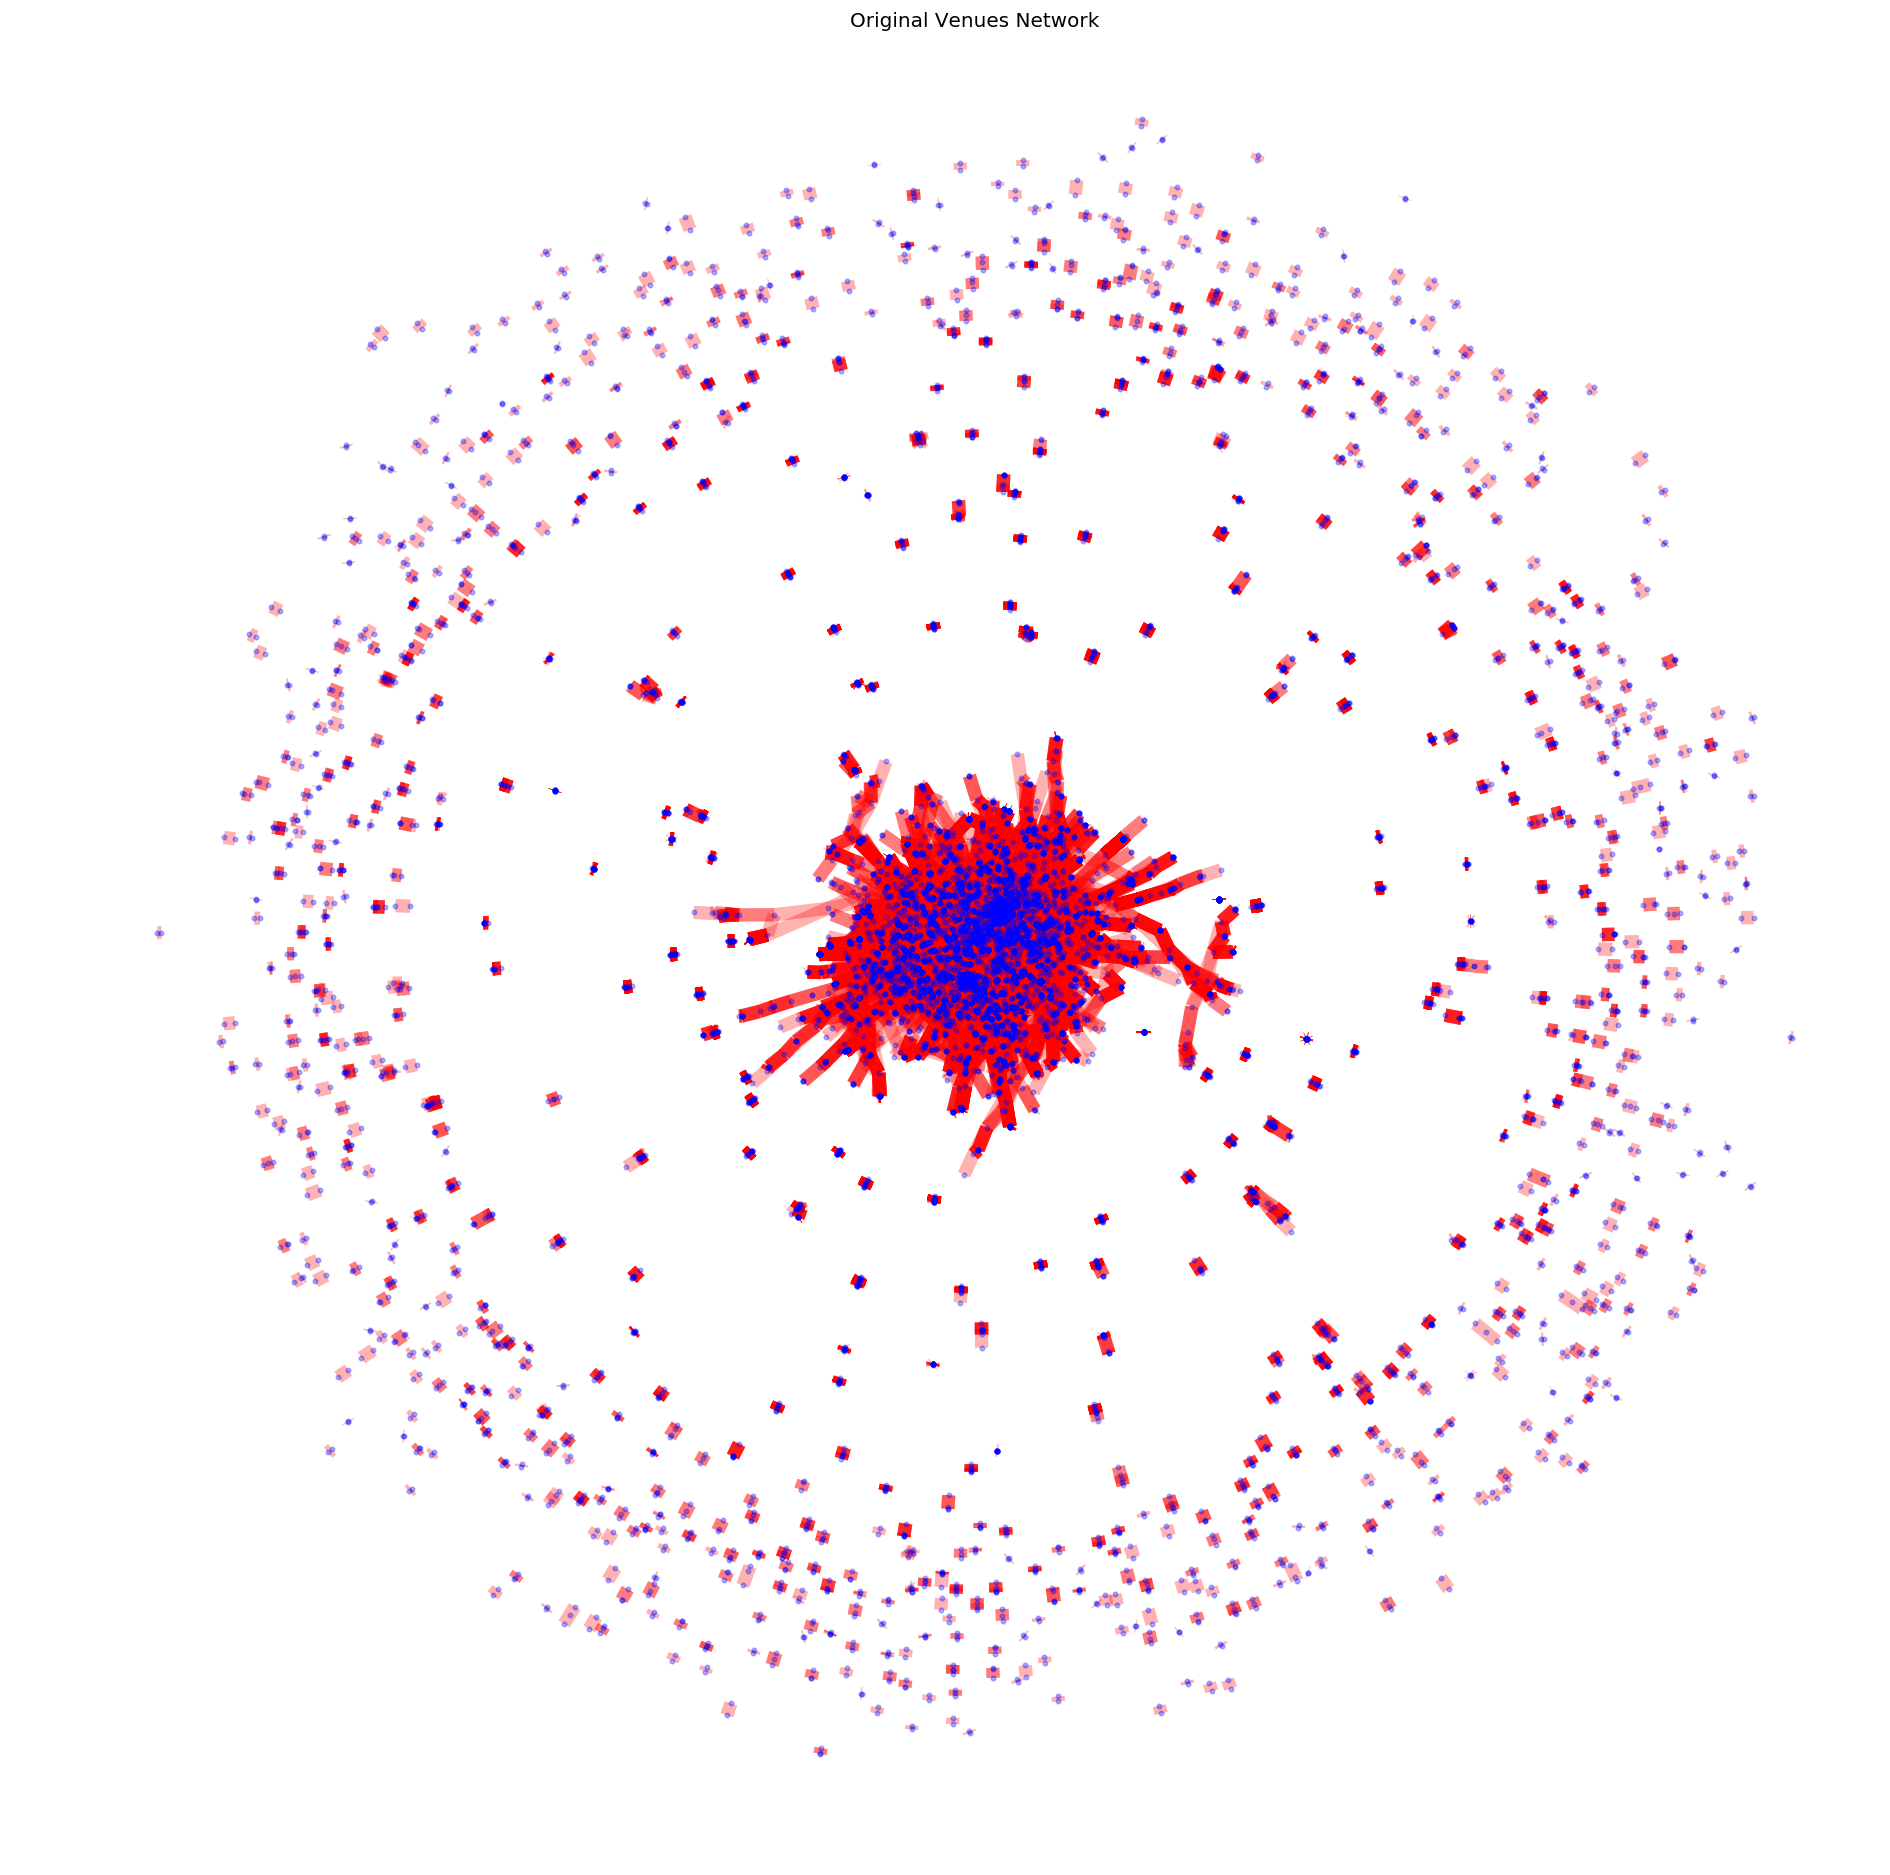

In [107]:
fig = plt.figure(figsize=(15,15), dpi=120)
nx.draw(venues_NW, with_labels=False, 
                             width=8, alpha=.3 ,node_size=7, node_color = "Blue", edge_color="Red", linewidths=1, label="Venues Network")
plt.title('Original Venues Network')
plt.show()
fig.savefig('venues_nw.png')

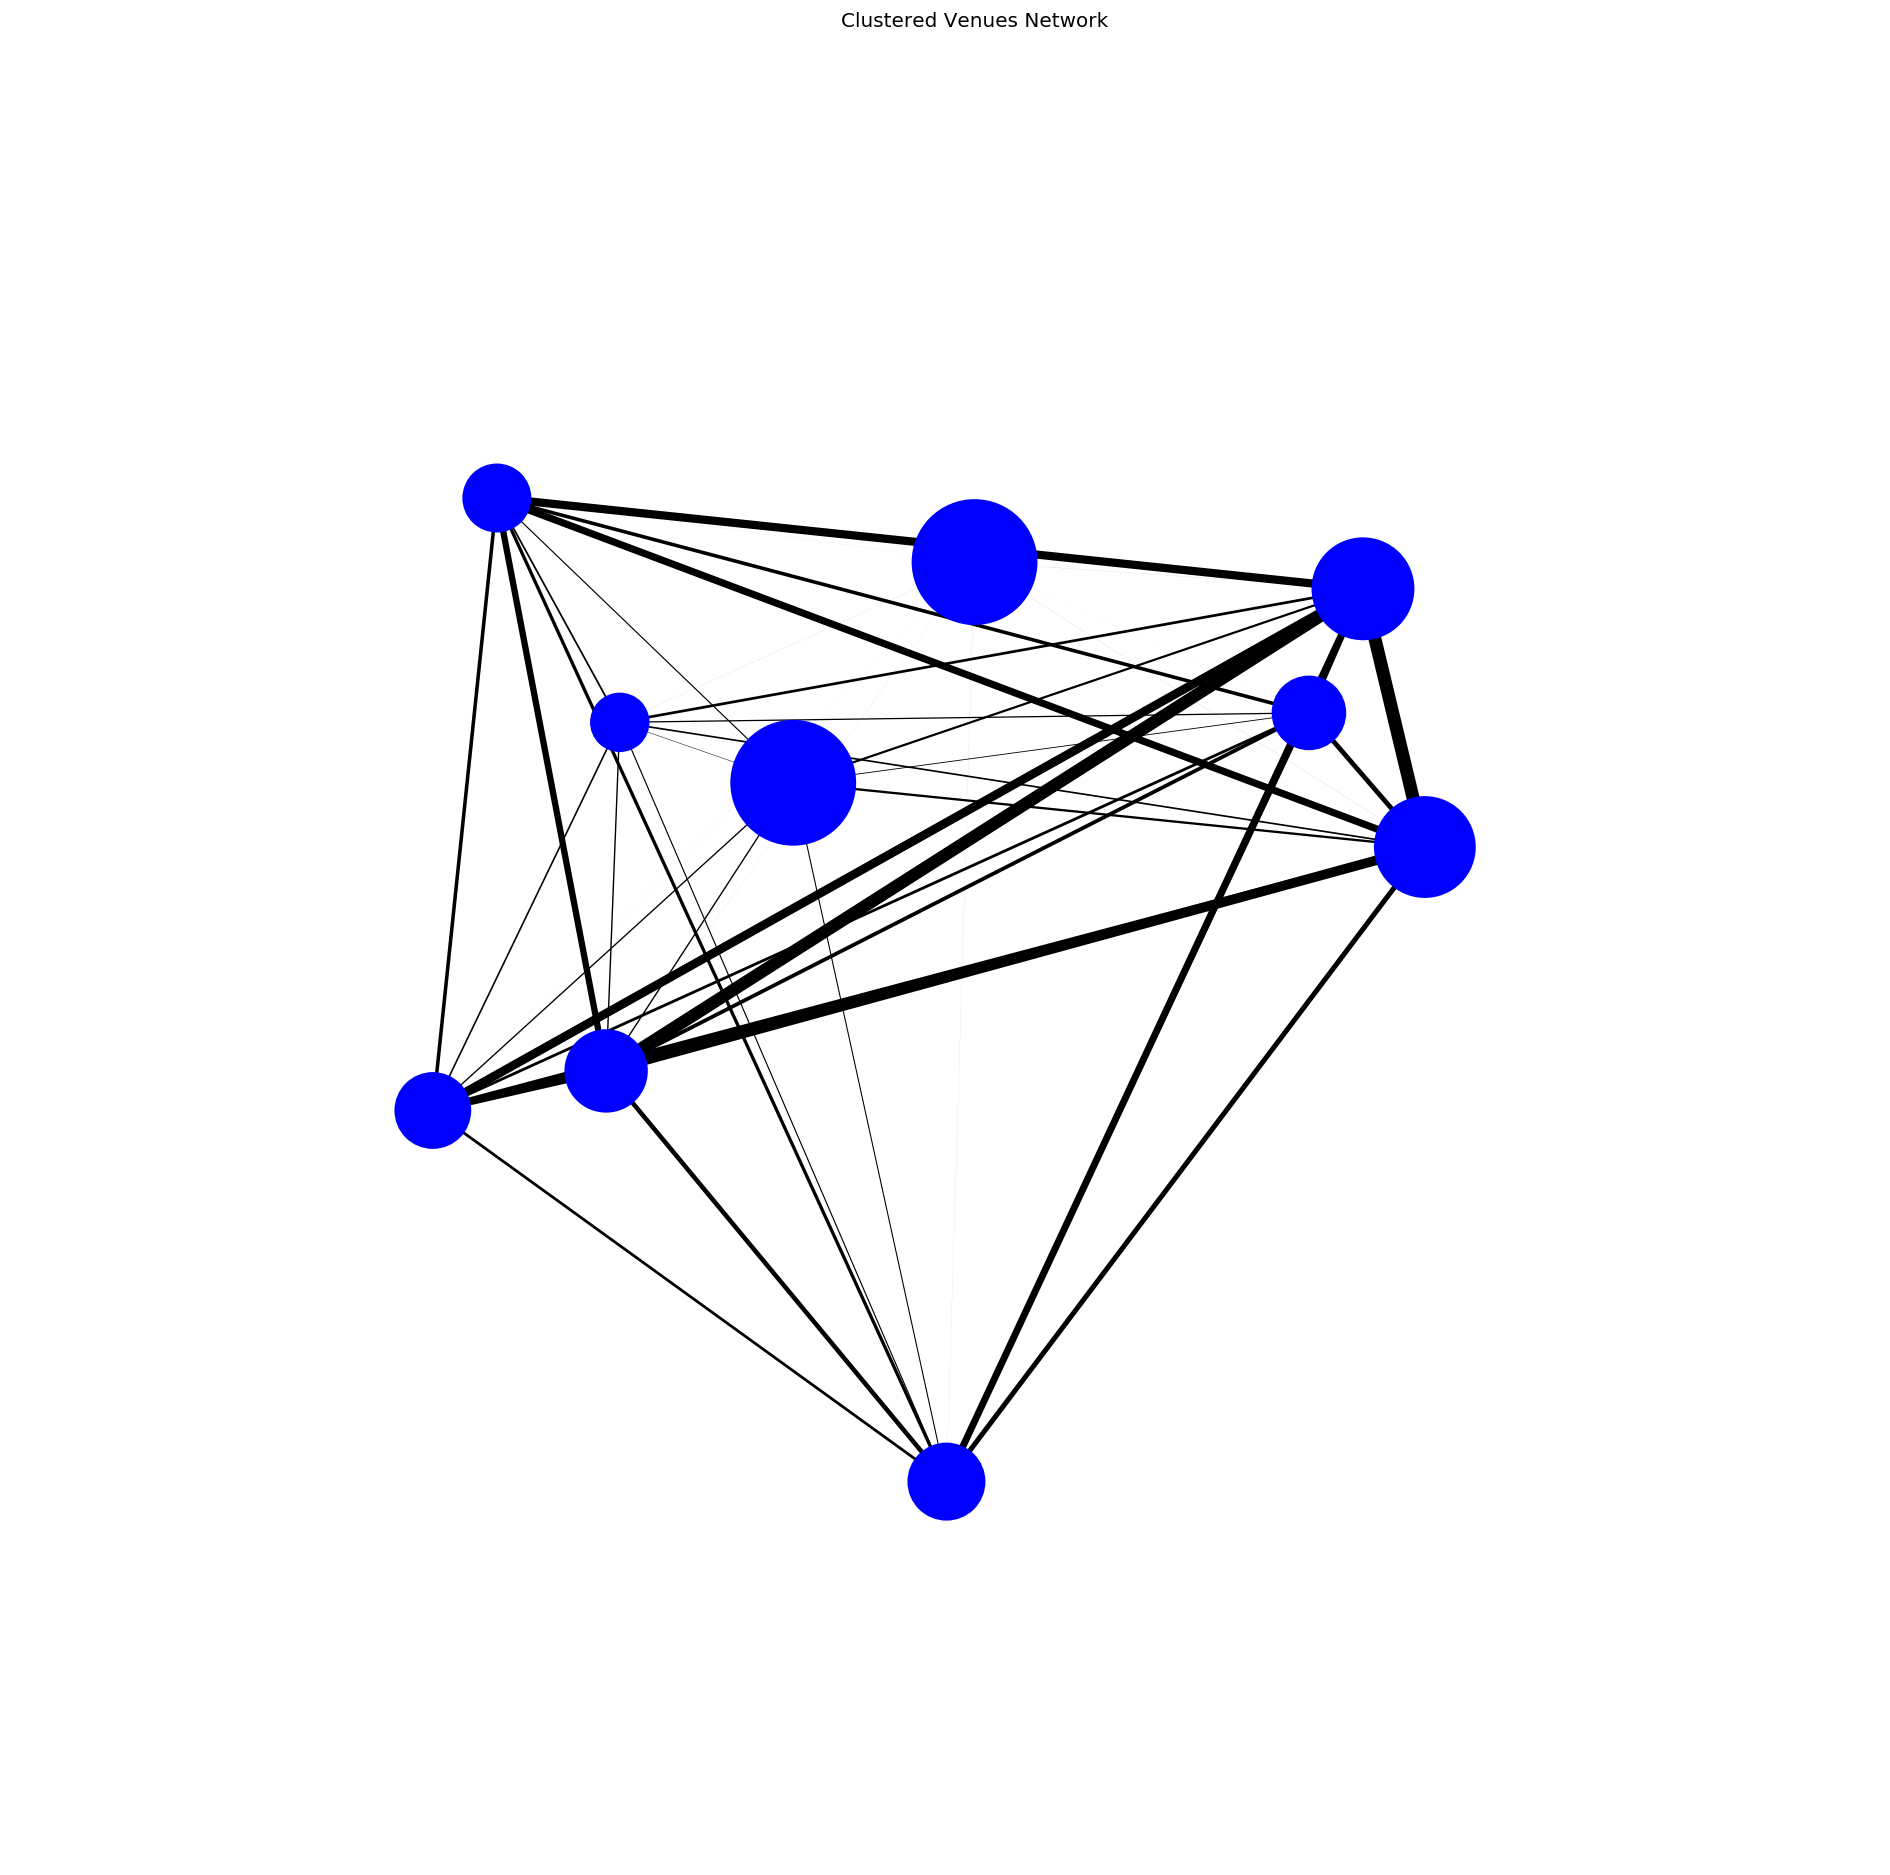

In [106]:

fig = plt.figure(figsize=(15,15), dpi=120)

nx.draw(BM, posBM, node_size=node_size, width=edge_width, with_labels=False, node_color = "Blue")
plt.title('Clustered Venues Network')

plt.show()
fig.savefig('venues_clust_nw.png')

In [80]:
list(BM.edges(data=True))[0]

(0, 1, {0: {'Number of Shared Groups': 1}, 1: {'Number of Shared Groups': 1}})

In [93]:
for i in BM.nodes():
  print("number of nodes of node {}: {}".format(BM.nodes[i], BM.nodes[i]["nnodes"]))

number of nodes of node {'graph': <networkx.classes.graphviews.SubGraph object at 0xa36282630>, 'nnodes': 1475, 'nedges': 7888, 'density': 0.007256169077570544}: 1475
number of nodes of node {'graph': <networkx.classes.graphviews.SubGraph object at 0xa362828d0>, 'nnodes': 480, 'nedges': 1555, 'density': 0.013526443980514962}: 480
number of nodes of node {'graph': <networkx.classes.graphviews.SubGraph object at 0xa2098da90>, 'nnodes': 839, 'nedges': 4517, 'density': 0.012849141351933345}: 839
number of nodes of node {'graph': <networkx.classes.graphviews.SubGraph object at 0xa2098d208>, 'nnodes': 2220, 'nedges': 7394, 'density': 0.0030019203520780806}: 2220
number of nodes of node {'graph': <networkx.classes.graphviews.SubGraph object at 0xa2098d2b0>, 'nnodes': 765, 'nedges': 2574, 'density': 0.008808130582075762}: 765
number of nodes of node {'graph': <networkx.classes.graphviews.SubGraph object at 0xa2098d358>, 'nnodes': 962, 'nedges': 5056, 'density': 0.01093801718151354}: 962
number

In [ ]:
color_dict = {}